In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer

import string
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer

# filter warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/email classification/SMS_train.csv', encoding='latin1')
test_df = pd.read_csv('/content/drive/MyDrive/email classification/SMS_test.csv', encoding='latin1')

# set S. No as index
train_df.set_index('S. No.', inplace=True)
test_df.set_index('S. No.', inplace=True)

# first few rows
train_df.head()

,Message_body,Label
S. No.,,
1,Rofl. Its true to its name,Non-Spam
2,The guy did some bitching but I acted like i'd...,Non-Spam
3,"Pity, * was in mood for that. So...any other s...",Non-Spam
4,Will ü b going to esplanade fr home?,Non-Spam
5,This is the 2nd time we have tried 2 contact u...,Spam


In [4]:
# shape of the data
print(train_df.shape, test_df.shape)

(957, 2) (125, 2)


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 957 entries, 1 to 957
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Message_body  957 non-null    object
 1   Label         957 non-null    object
dtypes: object(2)
memory usage: 22.4+ KB


In [6]:
# remane columns
# rename Message_body
train_df['Text'] = train_df['Message_body']
# test data
test_df['Text'] = test_df['Message_body']

# transform Label to the appropriate data type
train_df['Label'] = pd.Categorical(train_df['Label'])
test_df['Label'] = pd.Categorical(test_df['Label'])


# drop Message_body
train_df.drop('Message_body', axis=1, inplace=True)
test_df.drop('Message_body', axis=1, inplace=True)

train_df['Text']

,Text
S. No.,
1,Rofl. Its true to its name
2,The guy did some bitching but I acted like i'd...
3,"Pity, * was in mood for that. So...any other s..."
4,Will ü b going to esplanade fr home?
5,This is the 2nd time we have tried 2 contact u...
...,...
953,hows my favourite person today? r u workin har...
954,How much you got for cleaning
955,Sorry da. I gone mad so many pending works wha...


In [7]:
# descriptive statistics of train data
train_df.describe(include='object')

,Text
count,957
unique,945
top,"Sorry, I'll call later"
freq,4


In [8]:
# descriptive statistics of test data
test_df.describe(include='object')

,Text
count,125
unique,124
top,Congratulations ur awarded 500 of CD vouchers ...
freq,2


In [9]:
# check for null values
train_df.isna().sum()

,0
Label,0
Text,0


# CLEAN TEXTS

In [10]:
# Download the stopwords dataset
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
# clean texts
def clean_text(text):
    # remove special characters
    text = re.sub(r'[^a-zA-ZÀ-ú]+',' ',text)

    # change letter to lower case
    text = text.lower()

    # remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # remove whitespaces
    text = re.sub(r'\s+',' ', text).strip()
    return text


In [12]:
# apply transformaation to the data
train_df['Text'] = train_df['Text'].apply(lambda x : clean_text(x))
test_df['Text'] = test_df['Text'].apply(lambda x : clean_text(x))

In [13]:
# see transformation
train_df['Text'].head()

,Text
S. No.,
1,rofl its true to its name
2,the guy did some bitching but i acted like i d...
3,pity was in mood for that so any other suggest...
4,will b going to esplanade fr home
5,this is the nd time we have tried contact u u ...


In [14]:
# remove stopwords

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text.lower())
    return " ".join([token for token in tokens if token not in stop_words])

In [15]:
train_df['Text'] = train_df['Text'].apply(lambda x : remove_stopwords(x))
test_df['Text'] = test_df['Text'].apply(lambda x : remove_stopwords(x))

# STEMMING

In [16]:
# Stemming

def normalize_text(text):
    stemmer = SnowballStemmer('english')
    normalized_text = []

    # Handle potential non-string elements
    if not isinstance(text, str):
        return ""

    for word in text.split():
        stemmed_word = stemmer.stem(word)
        normalized_text.append(stemmed_word)

    return " ".join(normalized_text)

In [17]:
# apply transformation to training and test data

train_df['Text'] = train_df['Text'].apply(lambda x : normalize_text(x))
test_df['Text'] = test_df['Text'].apply(lambda x : normalize_text(x))

In [18]:
train_df['Text'].head(10)

,Text
S. No.,
1,rofl true name
2,guy bitch act like interest buy someth els nex...
3,piti mood suggest
4,b go esplanad fr home
5,nd time tri contact u u pound prize claim easi...
6,remind get pound free call credit detail great...
7,huh lei
8,wait til least wednesday see get
9,ard like dat lor


# VECTORIZATION

In [38]:
# vectorize words
max_words = 10000
vectorizer = CountVectorizer(max_features=max_words)
count_train = vectorizer.fit_transform(train_df['Text'])
count_test = vectorizer.transform(test_df['Text'])

# convert to sparse matrices(to be used as x_train & x_test)
x_train = count_train.toarray()
x_test = count_test.toarray()

In [20]:
vectorizer.get_feature_names_out()

array(['aa', 'aah', 'abdomen', ..., 'zed', 'zero', 'zs'], dtype=object)

In [21]:
count_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [22]:
# encode 'Label'
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train_df['Label'] = le.fit_transform(train_df['Label'])
test_df['Label'] = le.transform(test_df['Label'])

In [23]:
train_df.head(10)

,Label,Text
S. No.,,
1,0,rofl true name
2,0,guy bitch act like interest buy someth els nex...
3,0,piti mood suggest
4,0,b go esplanad fr home
5,1,nd time tri contact u u pound prize claim easi...
6,1,remind get pound free call credit detail great...
7,0,huh lei
8,0,wait til least wednesday see get
9,0,ard like dat lor


In [24]:
test_df.head()

,Label,Text
S. No.,,
1,1,upgrdcentr orang custom may claim free camera ...
2,1,loan purpos homeown tenant welcom previous ref...
3,1,congrat nokia video camera phone call call cos...
4,1,urgent mobil number award prize guarante call ...
5,1,someon contact date servic enter phone fanci f...


# MODELLING

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [40]:
# y_train and y_test
y_train = train_df['Label']
y_val = test_df['Label']


# LOGISTIC REGRESSION

In [41]:
# apply model
lr = LogisticRegression()
lr.fit(x_train, y_train)

LogisticRegression()

In [47]:
# prediction
y_pred = lr.predict(x_test)

In [48]:
# visualize first five five rows of y_val and y_pred
print(y_val[:5])
print(y_pred[:5])

S. No.
1    1
2    1
3    1
4    1
5    1
Name: Label, dtype: int64
[1 1 1 1 1]


In [49]:
# proportion of the prediction made on each class
print(np.unique(y_pred, return_counts=True))

(array([0, 1]), array([72, 53]))


In [50]:
# proportion of the actual class
print(np.unique(y_val, return_counts=True))

(array([0, 1]), array([49, 76]))


In [51]:
# get accuracy of model
accuracy_score(y_val, y_pred) * 100

81.6

In [53]:
# classification report
print('\nClassification Report')
print(classification_report(y_val, y_pred))


Classification Report
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        49
           1       1.00      0.70      0.82        76

    accuracy                           0.82       125
   macro avg       0.84      0.85      0.82       125
weighted avg       0.87      0.82      0.82       125



Text(50.722222222222214, 0.5, 'True Labels')

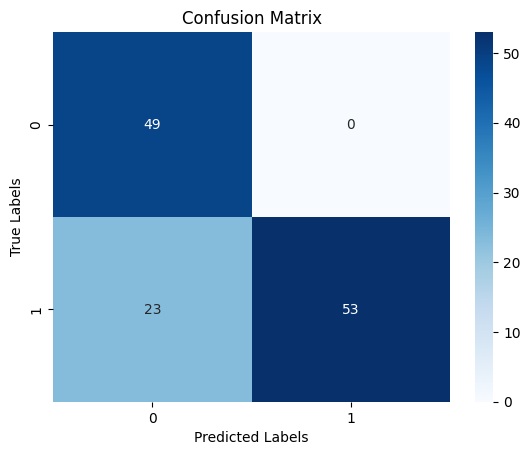

In [52]:
# confusion matrix
conf_mat = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# SUPPORT VECTOR MACHINE

In [54]:
from sklearn.svm import SVC

In [56]:
svc = SVC(kernel='linear')
svc.fit(x_train, y_train)

SVC(kernel='linear')

In [57]:
# prediction
y_pred = svc.predict(x_test)

In [58]:
# Evaluation
print('Accuracy:', accuracy_score(y_val, y_pred))
print('\nClassification Report')
print(classification_report(y_val, y_pred))
print('\nConfusion Matrix')
print(confusion_matrix(y_val, y_pred))


Accuracy: 0.88

Classification Report
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        49
           1       1.00      0.80      0.89        76

    accuracy                           0.88       125
   macro avg       0.88      0.90      0.88       125
weighted avg       0.91      0.88      0.88       125


Confusion Matrix
[[49  0]
 [15 61]]
